# Exercise 1: Error metrics

In this notebook we set out exercises to implement error metrics and use them in skforecast. The solutions we show are only one way of answering these questions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data loading and preparation

Data has been obtained from [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data), specifically `train.csv`. This dataset contains 913,000 sales transactions from 2013–01–01 to 2017–12–31 for 50 products (SKU) in 10 stores. The goal is to predict the next 7 days sales for 50 different items in one store using the available 5 years history.

In [2]:
from skforecast.datasets import fetch_dataset

# Load the data
data = fetch_dataset(name="store_sales", raw=True)
data.head()

store_sales
-----------
This dataset contains 913,000 sales transactions from 2013-01-01 to 2017-12-31
for 50 products (SKU) in 10 stores.
The original data was obtained from: inversion. (2018). Store Item Demand
Forecasting Challenge. Kaggle. https://kaggle.com/competitions/demand-
forecasting-kernels-only
Shape of the dataset: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


`ForecasterRecursiveMultiSeries` requires that each time series is a column in the dataframe and that the index is time-like (datetime or timestamp). 

So now we process the data to get dataframes in the required format.

In [3]:
# Data preprocessing

selected_store = 2
selected_items = data.item.unique()  # All items
# selected_items = [1, 2, 3, 4, 5] # Selection of items to reduce computation time

# Filter data to specific stores and products
mask = (data["store"] == selected_store) & (data["item"].isin(selected_items))
data = data[mask].copy()

# Convert `date` column to datetime
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

# Convert to one column per time series
data = pd.pivot_table(data=data, values="sales", index="date", columns="item")

# Reset column names
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]

# Explicitly set the frequency of the data to daily.
# This would introduce missing values for missing days.
data = data.asfreq("1D")

# Sort by time
data = data.sort_index()

data.head(4)

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0,41.0,19.0,21.0,4.0,34.0,39.0,49.0,28.0,51.0,...,11.0,25.0,36.0,12.0,45.0,43.0,12.0,45.0,29.0,43.0
2013-01-02,16.0,33.0,32.0,14.0,6.0,40.0,47.0,42.0,21.0,56.0,...,19.0,21.0,35.0,25.0,50.0,52.0,13.0,37.0,25.0,57.0
2013-01-03,16.0,46.0,26.0,12.0,12.0,41.0,43.0,46.0,29.0,46.0,...,23.0,20.0,52.0,18.0,56.0,30.0,5.0,45.0,30.0,45.0
2013-01-04,20.0,50.0,34.0,17.0,16.0,41.0,44.0,55.0,32.0,56.0,...,15.0,28.0,50.0,24.0,57.0,46.0,19.0,32.0,20.0,45.0


In [4]:
# Check if any missing values introduced
data.isnull().sum().any()

False

/var/folders/xw/0ks6s8x53lvf4p3xdqzfh9300000gn/T/ipykernel_25865/1227022470.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


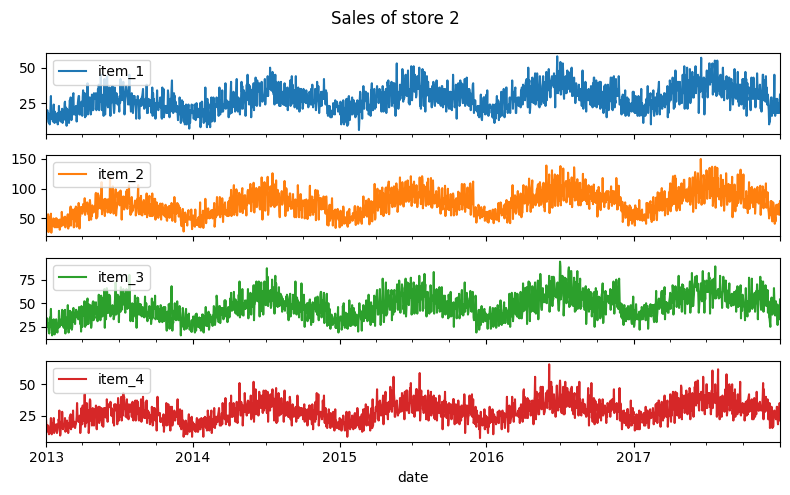

In [5]:
# Plot a subset of the time series
fig, ax = plt.subplots(figsize=(8, 5))
data.iloc[:, :4].plot(
    legend=True,
    subplots=True,
    sharex=True,
    title="Sales of store 2",
    ax=ax,
)
fig.tight_layout()

Let's add the day of the week to use as an exogenous feature.

In [6]:
data["day_of_week"] = data.index.weekday

# Analysis

We want to build an intuition about the characteristics (trend, outliers, seasonality, intermittency, etc.) and the range of values that the time series have.
This helps when deciding which error metrics to use.

Compute a set of summary statistics and/or plots to do this.

In [7]:
mean_sales_by_item = data.filter(like="item").mean()
mean_sales_by_item.head()

item_1    28.173604
item_2    75.316539
item_3    46.992333
item_4    28.234940
item_5    23.540526
dtype: float64

Text(0.5, 0, 'Mean sales')

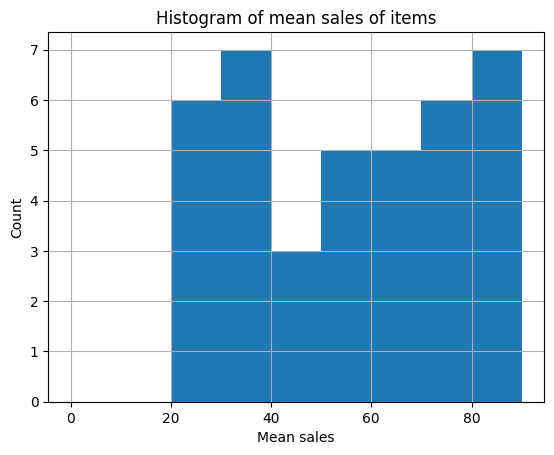

In [8]:
ax = mean_sales_by_item.hist(bins=np.arange(0, 100, 10))
ax.set_title("Histogram of mean sales of items")
ax.set_ylabel("Count")
ax.set_xlabel("Mean sales")

Plot the 5 largest and 5 smallest time series.

Text(0.5, 1.0, 'Items with the smallest mean sales')

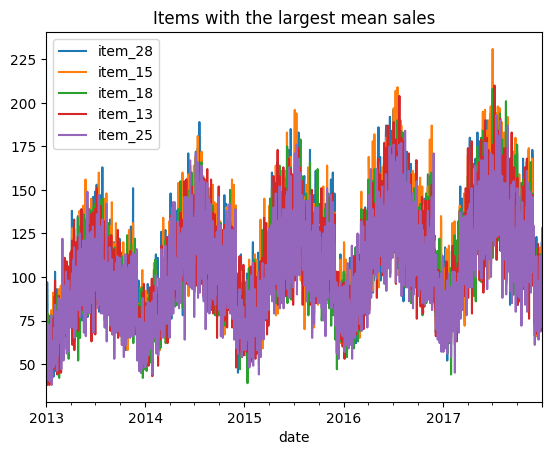

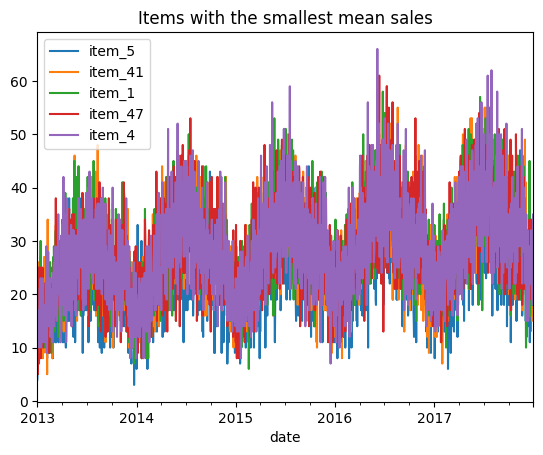

In [9]:
# The largest time series
largest_items = mean_sales_by_item.nlargest(5).index
ax = data.loc[:, largest_items].plot()
ax.set_title("Items with the largest mean sales")

# The smallest time series
smallest_items = mean_sales_by_item.nsmallest(5).index
ax = data.loc[:, smallest_items].plot()
ax.set_title("Items with the smallest mean sales")

We can see the time series has some trend and seasonality. There does not appear
to be any intermittency.

Check for any zero values.

In [10]:
(
data.filter(like="item") # Filter to columns referring to item sales
    .pipe(lambda df: df == 0) # Check if any values == 0
    .any()
    .values
    .sum() # Sum over all elements in dataframe to get total number of zeros
 )

0

There are no zero values.

So we have a dataset which has:
- Multiple time series which have vary in average value from ~20-90 (this is not a large spread, it's barely one order of magnitude)
- Trend
- Seasonality
- No intermittency or zero values


# Implementing custom error metrics

Error metrics that we can consider using are:
- To measure the bias: 
    - Average forecast bias: we compute the forecast bias, which is a scale independent measure, for each time series and then average over all time series.
- To measure the error:
    - Normalised RMSE or normalised deviation: these are pooled error metrics, which cannot currently be calculated natively in skforecast.
    - Average RMSSE or MASE:  we can compute the MASE or RMSSE, a scale independent metric, for each time series individually and then average the results to give our final metric. This cannot currently be calculated in skforecast as it requires the custom error function to have
    access to the training set. 
    - Average WAPE: we can compute the WAPE, a scale independent metric, for each time series individually and then average the results to give our final metric.

Create a function that takes `y_true` and `y_pred` as an argument and ouputs the 
weighted mean absolute percentage error (WAPE) metric defined as:

$ WAPE = \frac{\sum_t{|e_t|}}{\sum_t{|y_t|}} $

Note: The data does have trend, this would suggest we should not use WAPE. However,
as we are only forecasting 7 days into the future the magnitude of the trend in
the forecast horizon is negligible. 

In [11]:
def WAPE(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    sum_errors = np.sum(np.abs(y_true - y_pred))
    sum_abs_y = np.sum(np.abs(y_true))
    return sum_errors / sum_abs_y

Create a function that takes `y_true` and `y_pred` as an argument and ouputs the 
forecast bias metric defined as the mean error divided by the mean of the time series
in the forecast horizon:

$ FB = \frac{1/H\sum_t{e_t}}{1/H\sum_t{y_t}} = \frac{\sum_t{e_t}}{\sum_t{y_t}}$

In [12]:
def forecast_bias(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    sum_errors = np.sum(y_true - y_pred)
    sum_y = np.sum(y_true)
    return sum_errors / sum_y

# Using a custom error metric

Define a model to do recursive multistep forecasting for multiple independent time series.

In [13]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

# Traditional machine learning models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Multiple independent series forecasting (recursive)
from skforecast.recursive import ForecasterRecursiveMultiSeries

# Define parameters of a lightgbm
params_lgbm = {
    "n_estimators": 100,
    "learning_rate": 0.01,
    "max_depth": 10,
    "random_state": 8520,
    "verbose": -1,
}
forecaster = ForecasterRecursiveMultiSeries(
    regressor=LGBMRegressor(**params_lgbm),
    lags=31,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

Perform backtesting with refitting at every backtest step and compute the forecast bias
and WAPE for each time series.

In [14]:
from skforecast.model_selection import backtesting_forecaster_multiseries, TimeSeriesFold

In [15]:
# Define column names of target variables
target_cols = data.filter(like="item_").columns

# Define column names of exogenous features
exog_features = ["day_of_week"]

# Forecast horizon & number of steps to move forecast origin
steps = 7

# Number of datapoints to test over
n_backtesting = steps * 5

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Define how time series will be split during backtesting
cv = TimeSeriesFold(
    steps=steps,
    initial_train_size=initial_train_size,
    skip_folds=None,
    refit=True,
    fixed_train_size=False,
)

# Run backtesting
metric, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data[target_cols],
    exog=data[exog_features],
    cv=cv,
    metric=[forecast_bias, WAPE],
    verbose=True,
    show_progress=True,
)

Information of folds
--------------------
Number of observations used for initial training: 1791
Number of observations used for backtesting: 35
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2013-01-01 00:00:00 -- 2017-11-26 00:00:00  (n=1791)
    Validation: 2017-11-27 00:00:00 -- 2017-12-03 00:00:00  (n=7)
Fold: 1
    Training:   2013-01-01 00:00:00 -- 2017-12-03 00:00:00  (n=1798)
    Validation: 2017-12-04 00:00:00 -- 2017-12-10 00:00:00  (n=7)
Fold: 2
    Training:   2013-01-01 00:00:00 -- 2017-12-10 00:00:00  (n=1805)
    Validation: 2017-12-11 00:00:00 -- 2017-12-17 00:00:00  (n=7)
Fold: 3
    Training:   2013-01-01 00:00:00 -- 2017-12-17 00:00:00  (n=1812)
    Validation: 2017-12-18 00:00:00 -- 2017-12-24 00:00:00  (n=7)
Fold: 4
    Training:   2013-01-01 00:00:00 -- 2017-12-24 00:00:00  (n=1819)
    Validation: 2017-12-

  0%|          | 0/5 [00:00<?, ?it/s]

Average the forecast bias and WAPE over all items to get a single value for each
metric. Does your model over or under forecast?

In [16]:
error_metric_names = ["forecast_bias", "WAPE"]
metric[error_metric_names].mean()

forecast_bias   -0.142641
WAPE             0.189414
dtype: float64

In this case, because the forecast bias is negative, we can see the model overforecasts on average.

Plot a sample of the largest and smallest WAPE time series and their backtest
predictions.

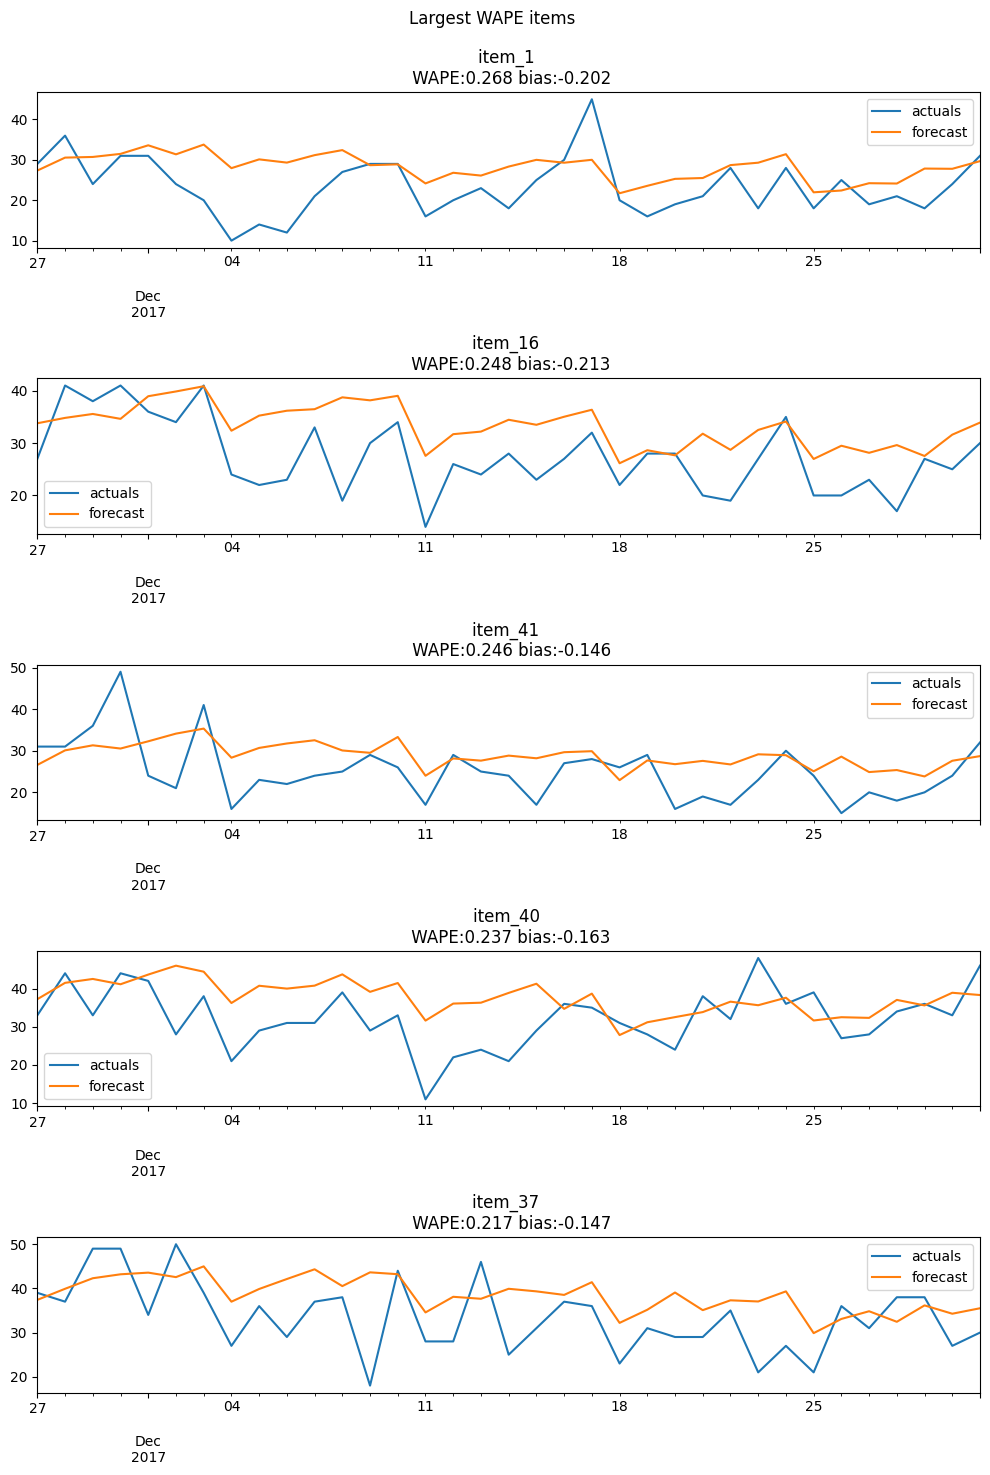

In [17]:
items_large_wape = metric.nlargest(n=5, columns=["WAPE"]).levels
backtest_period = predictions.index

n_series = len(items_large_wape)
fig, axs = plt.subplots(nrows=n_series, figsize=[10, n_series*3])

for ax, item in zip(axs, items_large_wape):
    wape = metric[metric["levels"]==item]["WAPE"].values[0]
    bias = metric[metric["levels"]==item]["forecast_bias"].values[0]
    data.loc[backtest_period, item].plot(ax=ax, label="actuals")
    predictions.loc[:, item].plot(ax=ax, label="forecast")
    ax.set_title(f"{item} \n WAPE:{wape:.3} bias:{bias:.3}")
    ax.legend()

fig.suptitle("Largest WAPE items \n")
plt.tight_layout()

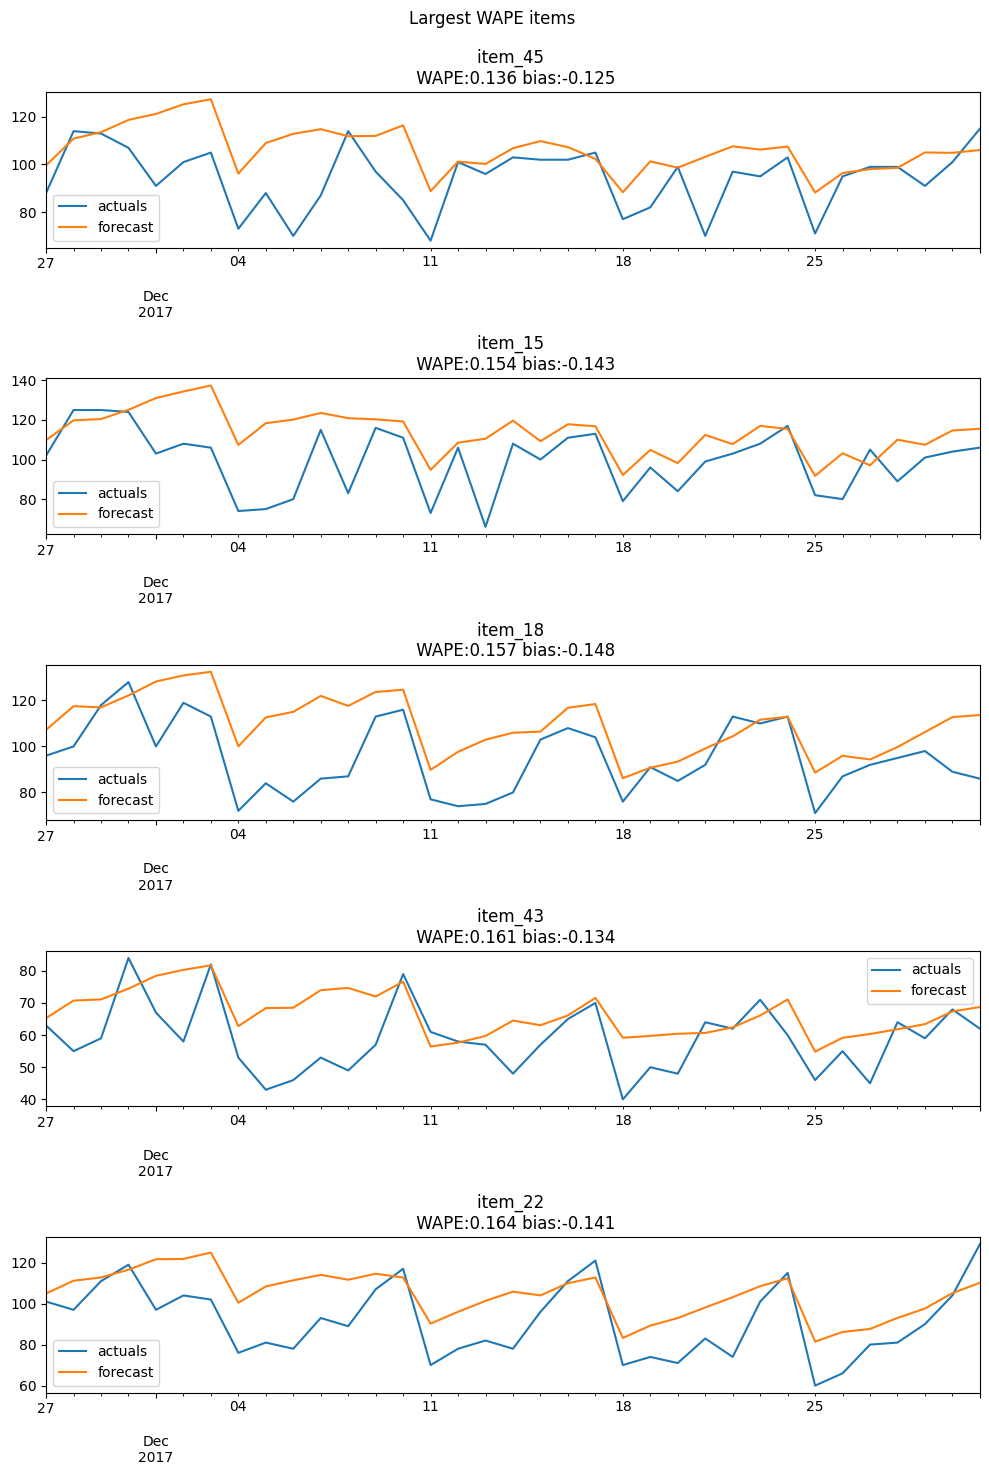

In [18]:
items_small_wape = metric.nsmallest(n=5, columns=["WAPE"]).levels
backtest_period = predictions.index

n_series = len(items_small_wape)
fig, axs = plt.subplots(nrows=n_series, figsize=[10, n_series*3])

for ax, item in zip(axs, items_small_wape):
    wape = metric[metric["levels"]==item]["WAPE"].values[0]
    bias = metric[metric["levels"]==item]["forecast_bias"].values[0]
    data.loc[backtest_period, item].plot(ax=ax, label="actuals")
    predictions.loc[:, item].plot(ax=ax, label="forecast")
    ax.set_title(f"{item} \n WAPE:{wape:.3} bias:{bias:.3}")
    ax.legend()

fig.suptitle("Largest WAPE items \n")
plt.tight_layout()